In [1]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras import backend as Kb
from keras.layers import Lambda
from keras.layers import Activation
from keras.layers import add, concatenate
from keras.layers import AveragePooling2D
from tensorflow.keras.utils import plot_model
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
 
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from operator import truediv
 
from plotly.offline import init_notebook_mode
 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.io import loadmat
import os
import spectral

In [2]:
def applyFA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    fa = FactorAnalysis(n_components=numComponents, random_state=0)
    newX = fa.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, fa
test_ratio = 0.7
windowSize = 24
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX
def createImageCubes(X, y, windowSize=8, removeZeroLabels = True):
    margin = int((windowSize) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin , c - margin:c + margin ]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [3]:
X=loadmat('../hyperspectral/PaviaU.mat')['paviaU']
y=loadmat('../hyperspectral/PaviaU_gt.mat')['paviaU_gt']

In [4]:
K = 3 
X,fa = applyFA(X,numComponents=K)

X.shape

(610, 340, 3)

In [5]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((42776, 24, 24, 3), (42776,))

In [6]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((12832, 24, 24, 3), (29944, 24, 24, 3), (12832,), (29944,))

In [7]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(12832, 9)

In [8]:
S1 = windowSize
L1 = K
output_units = 9

In [9]:
def WaveletTransformAxisY(batch_img):
    odd_img  = batch_img[:,0::2]
    even_img = batch_img[:,1::2]
    L = (odd_img + even_img) / 2.0
    H = Kb.abs(odd_img - even_img)
    return L, H

def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    tmp_batch = Kb.permute_dimensions(batch_img, [0, 2, 1])[:,:,::-1]
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = Kb.permute_dimensions(_dst_L, [0, 2, 1])[:,::-1,...]
    dst_H = Kb.permute_dimensions(_dst_H, [0, 2, 1])[:,::-1,...]
    return dst_L, dst_H
def Wavelet(batch_image):
    # make channel first image
    batch_image = Kb.permute_dimensions(batch_image, [0, 3, 1, 2])
    r = batch_image[:,0]
    g = batch_image[:,1]
    b = batch_image[:,2]

    # level 1 decomposition
    wavelet_L, wavelet_H = WaveletTransformAxisY(r)
    r_wavelet_LL, r_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    r_wavelet_HL, r_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(g)
    g_wavelet_LL, g_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    g_wavelet_HL, g_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(b)
    b_wavelet_LL, b_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    b_wavelet_HL, b_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH, 
                    g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH,
                    b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH]
    transform_batch = Kb.stack(wavelet_data, axis=1)

    # level 2 decomposition
    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(r_wavelet_LL)
    r_wavelet_LL2, r_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    r_wavelet_HL2, r_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(g_wavelet_LL)
    g_wavelet_LL2, g_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    g_wavelet_HL2, g_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(b_wavelet_LL)
    b_wavelet_LL2, b_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    b_wavelet_HL2, b_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)


    wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2, 
                    g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2,
                    b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2]
    transform_batch_l2 = Kb.stack(wavelet_data_l2, axis=1)

    # level 3 decomposition
    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(r_wavelet_LL2)
    r_wavelet_LL3, r_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    r_wavelet_HL3, r_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(g_wavelet_LL2)
    g_wavelet_LL3, g_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    g_wavelet_HL3, g_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL2)
    b_wavelet_LL3, b_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    b_wavelet_HL3, b_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3, 
                    g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3,
                    b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3]
    transform_batch_l3 = Kb.stack(wavelet_data_l3, axis=1)

    # level 4 decomposition
    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(r_wavelet_LL3)
    r_wavelet_LL4, r_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    r_wavelet_HL4, r_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(g_wavelet_LL3)
    g_wavelet_LL4, g_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    g_wavelet_HL4, g_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL3)
    b_wavelet_LL4, b_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    b_wavelet_HL4, b_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)


    wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4, 
                    g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4,
                    b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4]
    transform_batch_l4 = Kb.stack(wavelet_data_l4, axis=1)

    # print('shape before')
    # print(transform_batch.shape)
    # print(transform_batch_l2.shape)
    # print(transform_batch_l3.shape)
    # print(transform_batch_l4.shape)

    decom_level_1 = Kb.permute_dimensions(transform_batch, [0, 2, 3, 1])
    decom_level_2 = Kb.permute_dimensions(transform_batch_l2, [0, 2, 3, 1])
    decom_level_3 = Kb.permute_dimensions(transform_batch_l3, [0, 2, 3, 1])
    decom_level_4 = Kb.permute_dimensions(transform_batch_l4, [0, 2, 3, 1])
    
    # print('shape after')
    # print(decom_level_1.shape)
    # print(decom_level_2.shape)
    # print(decom_level_3.shape)
    # print(decom_level_4.shape)
    return [decom_level_1, decom_level_2, decom_level_3, decom_level_4]


def Wavelet_out_shape(input_shapes):
    # print('in to shape')
    return [tuple([None, 112, 112, 12]), tuple([None, 56, 56, 12]), 
            tuple([None, 28, 28, 12]), tuple([None, 14, 14, 12])]

In [10]:
    img_batch = Kb.zeros(shape=(8, 24, 24, 3), dtype='float32')
    Wavelet(img_batch)

[<tf.Tensor: shape=(8, 12, 12, 12), dtype=float32, numpy=
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          .

In [11]:
def get_wavelet_cnn_model():
 
    input_shape =  24, 24, 3
 
    input_ = Input(input_shape, name='the_input')
    # wavelet = Lambda(Wavelet, name='wavelet')
    wavelet = Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(input_)
    # print(input_l1)
    # print(input_l2)
    # print(input_l3)
    # print(input_l4)
    # level one decomposition starts
    conv_1 = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_1')(input_l1)
    norm_1 = BatchNormalization(name='norm_1')(conv_1)
    relu_1 = Activation('relu', name='relu_1')(norm_1)
 
    conv_1_2 = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2')(relu_1)
    norm_1_2 = BatchNormalization(name='norm_1_2')(conv_1_2)
    relu_1_2 = Activation('relu', name='relu_1_2')(norm_1_2)
 
    # level two decomposition starts
    conv_a = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_a')(input_l2)
    norm_a = BatchNormalization(name='norm_a')(conv_a)
    relu_a = Activation('relu', name='relu_a')(norm_a)
 
    # concate level one and level two decomposition
    concate_level_2 = concatenate([relu_1_2, relu_a])
    conv_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_2')(concate_level_2)
    norm_2 = BatchNormalization(name='norm_2')(conv_2)
    relu_2 = Activation('relu', name='relu_2')(norm_2)
 
    conv_2_2 = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_2_2')(relu_2)
    norm_2_2 = BatchNormalization(name='norm_2_2')(conv_2_2)
    relu_2_2 = Activation('relu', name='relu_2_2')(norm_2_2)
 
    # level three decomposition starts 
    conv_b = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_b')(input_l3)
    norm_b = BatchNormalization(name='norm_b')(conv_b)
    relu_b = Activation('relu', name='relu_b')(norm_b)
 
    conv_b_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_b_2')(relu_b)
    norm_b_2 = BatchNormalization(name='norm_b_2')(conv_b_2)
    relu_b_2 = Activation('relu', name='relu_b_2')(norm_b_2)
 
    # concate level two and level three decomposition 
    concate_level_3 = concatenate([relu_2_2, relu_b_2])
    conv_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_3')(concate_level_3)
    norm_3 = BatchNormalization(name='nomr_3')(conv_3)
    relu_3 = Activation('relu', name='relu_3')(norm_3)
 
    conv_3_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_3_2')(relu_3)
    norm_3_2 = BatchNormalization(name='norm_3_2')(conv_3_2)
    relu_3_2 = Activation('relu', name='relu_3_2')(norm_3_2)
 
    # level four decomposition start
    conv_c = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_c')(input_l4)
    norm_c = BatchNormalization(name='norm_c')(conv_c)
    relu_c = Activation('relu', name='relu_c')(norm_c)
 
    conv_c_2 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_2')(relu_c)
    norm_c_2 = BatchNormalization(name='norm_c_2')(conv_c_2)
    relu_c_2 = Activation('relu', name='relu_c_2')(norm_c_2)
 
    conv_c_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_3')(relu_c_2)
    norm_c_3 = BatchNormalization(name='norm_c_3')(conv_c_3)
    relu_c_3 = Activation('relu', name='relu_c_3')(norm_c_3)
 
    # concate level level three and level four decomposition
    concate_level_4 = concatenate([relu_3_2, relu_c_3])
    conv_4 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_4')(concate_level_4)
    norm_4 = BatchNormalization(name='norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(norm_4)
 
    conv_4_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_4_2')(relu_4)
    norm_4_2 = BatchNormalization(name='norm_4_2')(conv_4_2)
    relu_4_2 = Activation('relu', name='relu_4_2')(norm_4_2)
 
    conv_5_1 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_5_1')(relu_4_2)
    norm_5_1 = BatchNormalization(name='norm_5_1')(conv_5_1)
    relu_5_1 = Activation('relu', name='relu_5_1')(norm_5_1)
 
    pool_5_1 = AveragePooling2D(pool_size=(7, 7), strides=1, padding='same', name='avg_pool_5_1')(relu_5_1)
    #flat_5_1 = Flatten(name='flat_5_1')(pool_5_1) 
 
    #fc_5 = Dense(2048, name='fc_5')(flat_5_1)
    #norm_5 = BatchNormalization(name='norm_5')(fc_5)
    #relu_5 = Activation('relu', name='relu_5')(norm_5)
    #drop_5 = Dropout(0.5, name='drop_5')(relu_5)
 
    #fc_6 = Dense(2048, name='fc_6')(drop_5)
    #norm_6 = BatchNormalization(name='norm_6')(fc_6)
    #relu_6 = Activation('relu', name='relu_6')(norm_6)
    #drop_6 = Dropout(0.5, name='drop_6')(relu_6)
    flatten_layer = Flatten()(pool_5_1)
 
    dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    dense_layer2 = Dense(units=1024, activation='relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)
    output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)
 
    model = Model(inputs=input_, outputs=output_layer)
    model.summary()
    plot_model(model, to_file='wavelet_cnn_0.5.png')
 
    return model

In [12]:
model = get_wavelet_cnn_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 the_input (InputLayer)         [(None, 24, 24, 3)]  0           []                               
                                                                                                  
 wavelet (Lambda)               [(None, 12, 12, 12)  0           ['the_input[0][0]']              
                                , (None, 6, 6, 12),                                               
                                 (None, 3, 3, 12),                                                
                                 (None, 2, 2, 12)]                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 12, 12, 64)   6976        ['wavelet[0][0]']            

                                                                                                  
 relu_3_2 (Activation)          (None, 2, 2, 256)    0           ['norm_3_2[0][0]']               
                                                                                                  
 relu_c_3 (Activation)          (None, 2, 2, 256)    0           ['norm_c_3[0][0]']               
                                                                                                  
 concatenate_2 (Concatenate)    (None, 2, 2, 512)    0           ['relu_3_2[0][0]',               
                                                                  'relu_c_3[0][0]']               
                                                                                                  
 conv_4 (Conv2D)                (None, 2, 2, 256)    1179904     ['concatenate_2[0][0]']          
                                                                                                  
 norm_4 (B

In [13]:
#adam = Adam(lr=0.001, decay=1e-06)
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [14]:
filepath = (str('PU')+"_"+str(test_ratio)+"_best_model.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

In [15]:
history = model.fit(x=Xtrain, y=ytrain, batch_size = 30, epochs=10, callbacks=callbacks_list)

Epoch 1/10
428/428 [==============================] - ETA: 0s - loss: 0.3077 - accuracy: 0.8970
Epoch 1: saving model to PU_0.7_best_model.hdf5
428/428 [==============================] - 76s 172ms/step - loss: 0.3077 - accuracy: 0.8970
Epoch 2/10
428/428 [==============================] - ETA: 0s - loss: 0.0639 - accuracy: 0.9815
Epoch 2: saving model to PU_0.7_best_model.hdf5
428/428 [==============================] - 71s 167ms/step - loss: 0.0639 - accuracy: 0.9815
Epoch 3/10
428/428 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 0.9895
Epoch 3: saving model to PU_0.7_best_model.hdf5
428/428 [==============================] - 71s 166ms/step - loss: 0.0383 - accuracy: 0.9895
Epoch 4/10
428/428 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.9928
Epoch 4: saving model to PU_0.7_best_model.hdf5
428/428 [==============================] - 71s 166ms/step - loss: 0.0267 - accuracy: 0.9928
Epoch 5/10
428/428 [==============================] - ET

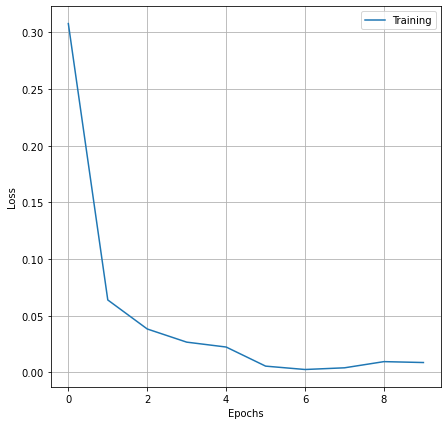

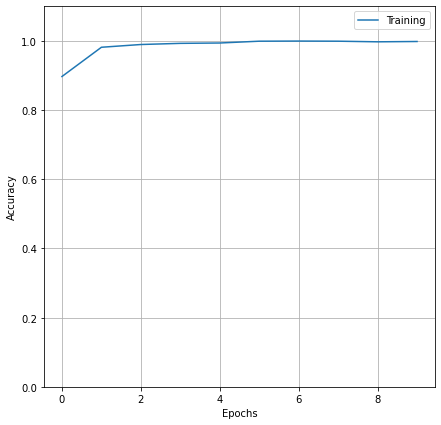

In [16]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs') 
plt.legend(['Training','Validation'], loc='upper right') 
plt.savefig(str('PU')+"_"+str(test_ratio)+"PAVIA_SPECTRALNET_loss_curve.jpg")
plt.show()
plt.figure(figsize=(7,7)) 
plt.ylim(0,1.1) 
plt.grid() 
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation']) 
plt.savefig(str('PU')+"_"+str(test_ratio)+"PAVIA_SPECTRALNET_acc_curve.jpg") 
plt.show()

In [17]:
model.save(str('PU')+"_"+str(test_ratio)+"_best_model.hdf5")

In [18]:
# load best weights
model.load_weights(str('PU')+"_"+str(test_ratio)+"_best_model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [19]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(29944, 24, 24, 3, 1)

In [20]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(29944, 9)

In [21]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)
 
classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification_report)

936/936 [==============================] - 17s 18ms/step
<function classification_report at 0x0000017605C2CDC0>


In [22]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [23]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [24]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,'PU')

936/936 [==============================] - 18s 18ms/step - loss: 0.0012 - accuracy: 0.9996


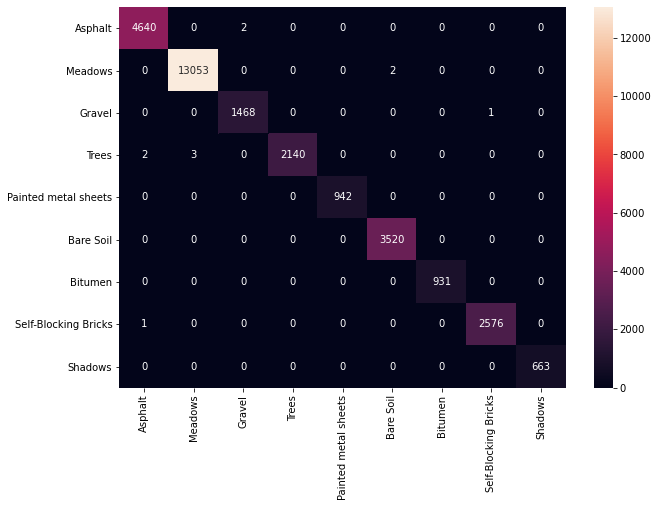

In [25]:
import pandas as pd
import seaborn as sns 
plt.figure(figsize = (10,7))

classes = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']

df_cm = pd.DataFrame(confusion, index = classes, columns = classes)

sns.heatmap(df_cm, annot=True, fmt='d')

plt.savefig(str('PU')+"_"+str(test_ratio)+"PAVIA_SPECTRALNET_ConfMatrix.jpg", dpi=100)
plt.show()

In [26]:
classification = str(classification)
confusion = str(confusion)
file_name = str('PU')+"_"+str(test_ratio)+"PAVIA_SPECTRALNET_classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [27]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [28]:
X=loadmat('../hyperspectral/PaviaU.mat')['paviaU']
y=loadmat('../hyperspectral/PaviaU_gt.mat')['paviaU_gt']

In [29]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize

In [30]:
K = 3
X,fa = applyFA(X, numComponents=K)

In [31]:
X = padWithZeros(X, PATCH_SIZE//2)

In [32]:
from tqdm import tqdm
# calculate the predicted image
outputs = np.zeros((height,width))
for i in tqdm(range(height), desc="Predictting...", ascii=False, ncols=75):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

Predictting...:   0%|                              | 0/610 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Predictting...:   0%|                      | 1/610 [00:01<14:04,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:   0%|                      | 2/610 [00:02<13:50,  1.37s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   0%|                      | 3/610 [00:04<14:00,  1.38s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:   1%|▏                     | 4/610 [00:05<14:54,  1.48s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   1%|▏                     | 5/610 [00:07<15:23,  1.53s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   1%|▏                     | 6/610 [00:08<15:40,  1.56s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:   1%|▎                     | 7/610 [00:10<15:29,  1.54s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:   1%|▎                     | 8/610 [00:11<14:49,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:   1%|▎                     | 9/610 [00:12<13:43,  1.37s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:   2%|▎                    | 10/610 [00:14<13:06,  1.31s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:   2%|▍                    | 11/610 [00:15<12:42,  1.27s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:   2%|▍                    | 12/610 [00:16<12:31,  1.26s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   2%|▍                    | 13/610 [00:17<11:48,  1.19s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   2%|▍                    | 14/610 [00:18<11:18,  1.14s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   2%|▌                    | 15/610 [00:19<11:05,  1.12s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   3%|▌                    | 16/610 [00:20<11:16,  1.14s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   3%|▌                    | 17/610 [00:22<11:45,  1.19s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   3%|▌                    | 18/610 [00:23<11:33,  1.17s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:   3%|▋                    | 19/610 [00:24<11:14,  1.14s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:   3%|▋                    | 20/610 [00:25<10:42,  1.09s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:   3%|▋                    | 21/610 [00:26<10:21,  1.05s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:   4%|▊                    | 22/610 [00:27<11:21,  1.16s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:   4%|▊                    | 23/610 [00:29<13:44,  1.40s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:   4%|▊                    | 24/610 [00:32<16:35,  1.70s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   4%|▊                    | 25/610 [00:34<17:45,  1.82s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   4%|▉                    | 26/610 [00:36<18:04,  1.86s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   4%|▉                    | 27/610 [00:37<17:48,  1.83s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:   5%|▉                    | 28/610 [00:39<17:18,  1.78s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   5%|▉                    | 29/610 [00:41<16:29,  1.70s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   5%|█                    | 30/610 [00:42<15:16,  1.58s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:   5%|█                    | 31/610 [00:43<14:15,  1.48s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:   5%|█                    | 32/610 [00:44<13:27,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:   5%|█▏                   | 33/610 [00:46<13:17,  1.38s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:   6%|█▏                   | 34/610 [00:47<13:36,  1.42s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:   6%|█▏                   | 35/610 [00:49<14:01,  1.46s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   6%|█▏                   | 36/610 [00:50<14:04,  1.47s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:   6%|█▎                   | 37/610 [00:51<13:22,  1.40s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   6%|█▎                   | 38/610 [00:53<12:57,  1.36s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   6%|█▎                   | 39/610 [00:54<12:16,  1.29s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   7%|█▍                   | 40/610 [00:55<12:06,  1.27s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   7%|█▍                   | 41/610 [00:56<12:18,  1.30s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   7%|█▍                   | 42/610 [00:58<12:16,  1.30s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:   7%|█▍                   | 43/610 [00:59<12:08,  1.28s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:   7%|█▌                   | 44/610 [01:00<12:18,  1.31s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   7%|█▌                   | 45/610 [01:02<12:53,  1.37s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:   8%|█▌                   | 46/610 [01:03<12:21,  1.32s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   8%|█▌                   | 47/610 [01:04<11:42,  1.25s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:   8%|█▋                   | 48/610 [01:05<10:20,  1.10s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:   8%|█▋                   | 49/610 [01:06<09:13,  1.01it/s]

1/1 [==============================] - 0s 24ms/step


Predictting...:   8%|█▋                   | 50/610 [01:06<08:26,  1.11it/s]

1/1 [==============================] - 0s 23ms/step


Predictting...:   8%|█▊                   | 51/610 [01:07<07:54,  1.18it/s]

1/1 [==============================] - 0s 24ms/step


Predictting...:   9%|█▊                   | 52/610 [01:08<07:46,  1.20it/s]

1/1 [==============================] - 0s 23ms/step


Predictting...:   9%|█▊                   | 53/610 [01:09<07:33,  1.23it/s]

1/1 [==============================] - 0s 22ms/step


Predictting...:   9%|█▊                   | 54/610 [01:09<07:17,  1.27it/s]

1/1 [==============================] - 0s 23ms/step


Predictting...:   9%|█▉                   | 55/610 [01:10<07:47,  1.19it/s]

1/1 [==============================] - 0s 23ms/step


Predictting...:   9%|█▉                   | 56/610 [01:11<08:37,  1.07it/s]

1/1 [==============================] - 0s 22ms/step


Predictting...:   9%|█▉                   | 57/610 [01:13<09:27,  1.03s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  10%|█▉                   | 58/610 [01:14<09:55,  1.08s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  10%|██                   | 59/610 [01:15<10:57,  1.19s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  10%|██                   | 60/610 [01:17<12:07,  1.32s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  10%|██                   | 61/610 [01:19<13:21,  1.46s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  10%|██▏                  | 62/610 [01:21<14:44,  1.61s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  10%|██▏                  | 63/610 [01:23<15:02,  1.65s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  10%|██▏                  | 64/610 [01:24<15:32,  1.71s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  11%|██▏                  | 65/610 [01:26<16:08,  1.78s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  11%|██▎                  | 66/610 [01:28<16:43,  1.84s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  11%|██▎                  | 67/610 [01:30<17:15,  1.91s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  11%|██▎                  | 68/610 [01:32<16:47,  1.86s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  11%|██▍                  | 69/610 [01:34<17:14,  1.91s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  11%|██▍                  | 70/610 [01:36<17:43,  1.97s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  12%|██▍                  | 71/610 [01:38<18:21,  2.04s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  12%|██▍                  | 72/610 [01:41<18:57,  2.11s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  12%|██▌                  | 73/610 [01:43<19:09,  2.14s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  12%|██▌                  | 74/610 [01:45<19:35,  2.19s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  12%|██▌                  | 75/610 [01:48<19:54,  2.23s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  12%|██▌                  | 76/610 [01:50<20:13,  2.27s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  13%|██▋                  | 77/610 [01:53<21:32,  2.42s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  13%|██▋                  | 78/610 [01:56<23:27,  2.65s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  13%|██▋                  | 79/610 [01:59<25:09,  2.84s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  13%|██▊                  | 80/610 [02:03<27:04,  3.07s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  13%|██▊                  | 81/610 [02:07<29:03,  3.30s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  13%|██▊                  | 82/610 [02:11<31:09,  3.54s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  14%|██▊                  | 83/610 [02:15<33:06,  3.77s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  14%|██▉                  | 84/610 [02:20<35:07,  4.01s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  14%|██▉                  | 85/610 [02:24<37:02,  4.23s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  14%|██▉                  | 86/610 [02:29<38:55,  4.46s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  14%|██▉                  | 87/610 [02:35<40:47,  4.68s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  14%|███                  | 88/610 [02:40<41:53,  4.82s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  15%|███                  | 89/610 [02:44<41:17,  4.75s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  15%|███                  | 90/610 [02:49<40:28,  4.67s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  15%|███▏                 | 91/610 [02:53<39:25,  4.56s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  15%|███▏                 | 92/610 [02:57<37:53,  4.39s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  15%|███▏                 | 93/610 [03:01<36:05,  4.19s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  15%|███▏                 | 94/610 [03:04<34:43,  4.04s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  16%|███▎                 | 95/610 [03:08<34:25,  4.01s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  16%|███▎                 | 96/610 [03:12<34:18,  4.00s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  16%|███▎                 | 97/610 [03:16<34:30,  4.04s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  16%|███▎                 | 98/610 [03:21<34:35,  4.05s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  16%|███▍                 | 99/610 [03:25<35:02,  4.11s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  16%|███▎                | 100/610 [03:29<35:14,  4.15s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  17%|███▎                | 101/610 [03:33<35:25,  4.18s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  17%|███▎                | 102/610 [03:37<35:12,  4.16s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  17%|███▍                | 103/610 [03:41<34:40,  4.10s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  17%|███▍                | 104/610 [03:45<33:52,  4.02s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  17%|███▍                | 105/610 [03:49<33:42,  4.00s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  17%|███▍                | 106/610 [03:53<32:40,  3.89s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  18%|███▌                | 107/610 [03:56<31:16,  3.73s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  18%|███▌                | 108/610 [04:00<30:34,  3.65s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  18%|███▌                | 109/610 [04:03<29:28,  3.53s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  18%|███▌                | 110/610 [04:06<28:01,  3.36s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  18%|███▋                | 111/610 [04:09<26:49,  3.23s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  18%|███▋                | 112/610 [04:12<25:38,  3.09s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  19%|███▋                | 113/610 [04:14<24:47,  2.99s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  19%|███▋                | 114/610 [04:17<23:30,  2.84s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  19%|███▊                | 115/610 [04:19<22:44,  2.76s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  19%|███▊                | 116/610 [04:22<21:23,  2.60s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  19%|███▊                | 117/610 [04:24<20:01,  2.44s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  19%|███▊                | 118/610 [04:26<19:03,  2.32s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  20%|███▉                | 119/610 [04:28<17:58,  2.20s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  20%|███▉                | 120/610 [04:30<17:28,  2.14s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  20%|███▉                | 121/610 [04:31<16:35,  2.03s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  20%|████                | 122/610 [04:33<15:45,  1.94s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  20%|████                | 123/610 [04:35<14:59,  1.85s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  20%|████                | 124/610 [04:36<14:18,  1.77s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  20%|████                | 125/610 [04:38<13:48,  1.71s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  21%|████▏               | 126/610 [04:40<13:34,  1.68s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  21%|████▏               | 127/610 [04:41<12:55,  1.61s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  21%|████▏               | 128/610 [04:42<12:27,  1.55s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  21%|████▏               | 129/610 [04:44<12:21,  1.54s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  21%|████▎               | 130/610 [04:45<12:03,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  21%|████▎               | 131/610 [04:47<11:43,  1.47s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  22%|████▎               | 132/610 [04:48<11:03,  1.39s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  22%|████▎               | 133/610 [04:49<10:19,  1.30s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  22%|████▍               | 134/610 [04:50<10:03,  1.27s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  22%|████▍               | 135/610 [04:51<10:02,  1.27s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  22%|████▍               | 136/610 [04:53<10:31,  1.33s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  22%|████▍               | 137/610 [04:55<11:24,  1.45s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  23%|████▌               | 138/610 [04:56<12:02,  1.53s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  23%|████▌               | 139/610 [04:58<12:53,  1.64s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  23%|████▌               | 140/610 [05:00<14:08,  1.81s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  23%|████▌               | 141/610 [05:03<14:46,  1.89s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  23%|████▋               | 142/610 [05:05<15:27,  1.98s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  23%|████▋               | 143/610 [05:07<16:26,  2.11s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  24%|████▋               | 144/610 [05:09<16:10,  2.08s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  24%|████▊               | 145/610 [05:11<16:38,  2.15s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  24%|████▊               | 146/610 [05:14<17:41,  2.29s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  24%|████▊               | 147/610 [05:17<18:48,  2.44s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  24%|████▊               | 148/610 [05:20<19:59,  2.60s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  24%|████▉               | 149/610 [05:23<20:40,  2.69s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  25%|████▉               | 150/610 [05:26<20:56,  2.73s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  25%|████▉               | 151/610 [05:28<20:59,  2.74s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  25%|████▉               | 152/610 [05:31<20:22,  2.67s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  25%|█████               | 153/610 [05:33<20:03,  2.63s/it]

1/1 [==============================] - 0s 22ms/step


Predictting...:  25%|█████               | 154/610 [05:36<19:13,  2.53s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  25%|█████               | 155/610 [05:38<18:44,  2.47s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  26%|█████               | 156/610 [05:41<19:50,  2.62s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  26%|█████▏              | 157/610 [05:44<20:17,  2.69s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  26%|█████▏              | 158/610 [05:47<21:13,  2.82s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  26%|█████▏              | 159/610 [05:50<22:11,  2.95s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  26%|█████▏              | 160/610 [05:54<23:15,  3.10s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  26%|█████▎              | 161/610 [05:57<24:28,  3.27s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  27%|█████▎              | 162/610 [06:01<25:21,  3.40s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  27%|█████▎              | 163/610 [06:05<26:06,  3.51s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  27%|█████▍              | 164/610 [06:09<26:47,  3.60s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  27%|█████▍              | 165/610 [06:13<27:43,  3.74s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  27%|█████▍              | 166/610 [06:17<28:43,  3.88s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  27%|█████▍              | 167/610 [06:21<29:46,  4.03s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  28%|█████▌              | 168/610 [06:25<29:35,  4.02s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  28%|█████▌              | 169/610 [06:29<29:51,  4.06s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  28%|█████▌              | 170/610 [06:33<29:28,  4.02s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  28%|█████▌              | 171/610 [06:37<28:24,  3.88s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  28%|█████▋              | 172/610 [06:40<27:32,  3.77s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  28%|█████▋              | 173/610 [06:44<26:55,  3.70s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  29%|█████▋              | 174/610 [06:47<25:59,  3.58s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  29%|█████▋              | 175/610 [06:50<25:11,  3.47s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  29%|█████▊              | 176/610 [06:54<25:08,  3.47s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  29%|█████▊              | 177/610 [06:57<25:09,  3.49s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  29%|█████▊              | 178/610 [07:01<24:55,  3.46s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  29%|█████▊              | 179/610 [07:04<24:43,  3.44s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  30%|█████▉              | 180/610 [07:08<24:33,  3.43s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  30%|█████▉              | 181/610 [07:11<24:06,  3.37s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  30%|█████▉              | 182/610 [07:14<24:31,  3.44s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  30%|██████              | 183/610 [07:17<23:27,  3.30s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  30%|██████              | 184/610 [07:20<22:51,  3.22s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  30%|██████              | 185/610 [07:24<22:25,  3.17s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  30%|██████              | 186/610 [07:26<21:45,  3.08s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  31%|██████▏             | 187/610 [07:29<21:07,  3.00s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  31%|██████▏             | 188/610 [07:32<20:34,  2.93s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  31%|██████▏             | 189/610 [07:35<20:41,  2.95s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  31%|██████▏             | 190/610 [07:38<20:41,  2.96s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  31%|██████▎             | 191/610 [07:41<20:43,  2.97s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  31%|██████▎             | 192/610 [07:44<20:42,  2.97s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  32%|██████▎             | 193/610 [07:47<20:40,  2.98s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  32%|██████▎             | 194/610 [07:50<20:38,  2.98s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  32%|██████▍             | 195/610 [07:53<20:14,  2.93s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  32%|██████▍             | 196/610 [07:55<19:58,  2.89s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  32%|██████▍             | 197/610 [07:59<20:11,  2.93s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  32%|██████▍             | 198/610 [08:02<20:19,  2.96s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  33%|██████▌             | 199/610 [08:04<19:48,  2.89s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  33%|██████▌             | 200/610 [08:07<20:20,  2.98s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  33%|██████▌             | 201/610 [08:10<20:02,  2.94s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  33%|██████▌             | 202/610 [08:13<19:48,  2.91s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  33%|██████▋             | 203/610 [08:16<19:58,  2.95s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  33%|██████▋             | 204/610 [08:19<20:38,  3.05s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  34%|██████▋             | 205/610 [08:23<20:33,  3.04s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  34%|██████▊             | 206/610 [08:26<20:39,  3.07s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  34%|██████▊             | 207/610 [08:29<20:45,  3.09s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  34%|██████▊             | 208/610 [08:32<20:49,  3.11s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  34%|██████▊             | 209/610 [08:35<20:10,  3.02s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  34%|██████▉             | 210/610 [08:38<19:56,  2.99s/it]

1/1 [==============================] - 0s 23ms/step


Predictting...:  35%|██████▉             | 211/610 [08:41<19:44,  2.97s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  35%|██████▉             | 212/610 [08:44<20:00,  3.02s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  35%|██████▉             | 213/610 [08:47<19:42,  2.98s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  35%|███████             | 214/610 [08:49<19:15,  2.92s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  35%|███████             | 215/610 [08:52<19:18,  2.93s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  35%|███████             | 216/610 [08:55<19:16,  2.94s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  36%|███████             | 217/610 [08:58<18:54,  2.89s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  36%|███████▏            | 218/610 [09:01<18:12,  2.79s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  36%|███████▏            | 219/610 [09:03<17:29,  2.68s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  36%|███████▏            | 220/610 [09:06<17:10,  2.64s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  36%|███████▏            | 221/610 [09:08<17:21,  2.68s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  36%|███████▎            | 222/610 [09:11<17:24,  2.69s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  37%|███████▎            | 223/610 [09:14<17:46,  2.76s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  37%|███████▎            | 224/610 [09:17<18:20,  2.85s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  37%|███████▍            | 225/610 [09:20<18:29,  2.88s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  37%|███████▍            | 226/610 [09:23<18:59,  2.97s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  37%|███████▍            | 227/610 [09:26<18:34,  2.91s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  37%|███████▍            | 228/610 [09:29<18:30,  2.91s/it]

1/1 [==============================] - 0s 24ms/step


Predictting...:  38%|███████▌            | 229/610 [09:31<17:56,  2.83s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  38%|███████▌            | 230/610 [09:34<17:58,  2.84s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  38%|███████▌            | 231/610 [09:38<18:30,  2.93s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  38%|███████▌            | 232/610 [09:41<19:02,  3.02s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  38%|███████▋            | 233/610 [09:44<19:40,  3.13s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  38%|███████▋            | 234/610 [09:48<20:37,  3.29s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  39%|███████▋            | 235/610 [09:51<20:54,  3.34s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  39%|███████▋            | 236/610 [09:54<19:48,  3.18s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  39%|███████▊            | 237/610 [09:57<18:49,  3.03s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  39%|███████▊            | 238/610 [09:59<17:54,  2.89s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  39%|███████▊            | 239/610 [10:02<17:22,  2.81s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  39%|███████▊            | 240/610 [10:04<16:39,  2.70s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  40%|███████▉            | 241/610 [10:07<16:15,  2.64s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  40%|███████▉            | 242/610 [10:10<16:43,  2.73s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  40%|███████▉            | 243/610 [10:13<17:14,  2.82s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  40%|████████            | 244/610 [10:16<17:54,  2.93s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  40%|████████            | 245/610 [10:19<18:13,  3.00s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  40%|████████            | 246/610 [10:22<18:08,  2.99s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  40%|████████            | 247/610 [10:25<18:08,  3.00s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  41%|████████▏           | 248/610 [10:29<18:50,  3.12s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  41%|████████▏           | 249/610 [10:32<18:34,  3.09s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  41%|████████▏           | 250/610 [10:35<18:36,  3.10s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  41%|████████▏           | 251/610 [10:37<17:45,  2.97s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  41%|████████▎           | 252/610 [10:40<17:44,  2.97s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  41%|████████▎           | 253/610 [10:43<17:35,  2.96s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  42%|████████▎           | 254/610 [10:46<16:48,  2.83s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  42%|████████▎           | 255/610 [10:48<16:08,  2.73s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  42%|████████▍           | 256/610 [10:51<15:58,  2.71s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  42%|████████▍           | 257/610 [10:53<15:26,  2.62s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  42%|████████▍           | 258/610 [10:55<14:14,  2.43s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  42%|████████▍           | 259/610 [10:57<13:04,  2.24s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  43%|████████▌           | 260/610 [10:59<11:51,  2.03s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  43%|████████▌           | 261/610 [11:00<10:30,  1.81s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  43%|████████▌           | 262/610 [11:01<09:08,  1.58s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  43%|████████▌           | 263/610 [11:03<09:00,  1.56s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  43%|████████▋           | 264/610 [11:04<09:16,  1.61s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  43%|████████▋           | 265/610 [11:06<09:15,  1.61s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  44%|████████▋           | 266/610 [11:08<09:33,  1.67s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  44%|████████▊           | 267/610 [11:10<09:56,  1.74s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  44%|████████▊           | 268/610 [11:12<10:30,  1.84s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  44%|████████▊           | 269/610 [11:14<11:11,  1.97s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  44%|████████▊           | 270/610 [11:17<12:12,  2.15s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  44%|████████▉           | 271/610 [11:19<13:03,  2.31s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  45%|████████▉           | 272/610 [11:22<13:22,  2.38s/it]

1/1 [==============================] - 0s 25ms/step


Predictting...:  45%|████████▉           | 273/610 [11:24<13:40,  2.43s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  45%|████████▉           | 274/610 [11:27<14:20,  2.56s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  45%|█████████           | 275/610 [11:30<14:48,  2.65s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  45%|█████████           | 276/610 [11:33<15:32,  2.79s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  45%|█████████           | 277/610 [11:37<16:35,  2.99s/it]

1/1 [==============================] - 0s 29ms/step


Predictting...:  46%|█████████           | 278/610 [11:40<17:48,  3.22s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  46%|█████████▏          | 279/610 [11:44<18:47,  3.40s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  46%|█████████▏          | 280/610 [11:48<19:27,  3.54s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  46%|█████████▏          | 281/610 [11:52<20:07,  3.67s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  46%|█████████▏          | 282/610 [11:56<20:27,  3.74s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  46%|█████████▎          | 283/610 [12:00<20:32,  3.77s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  47%|█████████▎          | 284/610 [12:04<20:41,  3.81s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  47%|█████████▎          | 285/610 [12:08<21:15,  3.92s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  47%|█████████▍          | 286/610 [12:12<21:15,  3.94s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  47%|█████████▍          | 287/610 [12:16<21:41,  4.03s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  47%|█████████▍          | 288/610 [12:21<22:33,  4.20s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  47%|█████████▍          | 289/610 [12:25<22:28,  4.20s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  48%|█████████▌          | 290/610 [12:29<22:16,  4.18s/it]

1/1 [==============================] - 0s 30ms/step


Predictting...:  48%|█████████▌          | 291/610 [12:34<22:47,  4.29s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  48%|█████████▌          | 292/610 [12:38<23:17,  4.40s/it]

1/1 [==============================] - 0s 26ms/step


Predictting...:  48%|█████████▌          | 293/610 [12:43<23:47,  4.50s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  48%|█████████▋          | 294/610 [12:48<24:14,  4.60s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  48%|█████████▋          | 295/610 [12:52<24:10,  4.61s/it]

1/1 [==============================] - 0s 29ms/step


Predictting...:  49%|█████████▋          | 296/610 [12:57<23:51,  4.56s/it]

1/1 [==============================] - 0s 29ms/step


Predictting...:  49%|█████████▋          | 297/610 [13:01<23:23,  4.48s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  49%|█████████▊          | 298/610 [13:06<23:38,  4.55s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  49%|█████████▊          | 299/610 [13:10<23:42,  4.57s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  49%|█████████▊          | 300/610 [13:15<24:07,  4.67s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  49%|█████████▊          | 301/610 [13:21<25:16,  4.91s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  50%|█████████▉          | 302/610 [13:27<26:40,  5.20s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  50%|█████████▉          | 303/610 [13:32<27:10,  5.31s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  50%|█████████▉          | 304/610 [13:37<26:57,  5.28s/it]

1/1 [==============================] - 0s 29ms/step


Predictting...:  50%|██████████          | 305/610 [13:43<26:28,  5.21s/it]

1/1 [==============================] - 0s 30ms/step


Predictting...:  50%|██████████          | 306/610 [13:48<26:08,  5.16s/it]

1/1 [==============================] - 0s 29ms/step


Predictting...:  50%|██████████          | 307/610 [13:52<25:32,  5.06s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  50%|██████████          | 308/610 [13:57<25:20,  5.04s/it]

1/1 [==============================] - 0s 29ms/step


Predictting...:  51%|██████████▏         | 309/610 [14:03<25:30,  5.09s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  51%|██████████▏         | 310/610 [14:09<27:03,  5.41s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  51%|██████████▏         | 311/610 [14:15<28:09,  5.65s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  51%|██████████▏         | 312/610 [14:21<28:38,  5.77s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  51%|██████████▎         | 313/610 [14:27<29:07,  5.88s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  51%|██████████▎         | 314/610 [14:33<29:00,  5.88s/it]

1/1 [==============================] - 0s 29ms/step


Predictting...:  52%|██████████▎         | 315/610 [14:39<29:37,  6.03s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  52%|██████████▎         | 316/610 [14:46<30:13,  6.17s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  52%|██████████▍         | 317/610 [14:52<30:44,  6.29s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  52%|██████████▍         | 318/610 [14:59<31:41,  6.51s/it]

1/1 [==============================] - 0s 30ms/step


Predictting...:  52%|██████████▍         | 319/610 [15:07<32:46,  6.76s/it]

1/1 [==============================] - 0s 29ms/step


Predictting...:  52%|██████████▍         | 320/610 [15:14<33:08,  6.86s/it]

1/1 [==============================] - 0s 30ms/step


Predictting...:  53%|██████████▌         | 321/610 [15:21<34:01,  7.06s/it]

1/1 [==============================] - 0s 27ms/step


Predictting...:  53%|██████████▌         | 322/610 [15:29<34:12,  7.13s/it]

1/1 [==============================] - 0s 30ms/step


Predictting...:  53%|██████████▌         | 323/610 [15:36<34:57,  7.31s/it]

1/1 [==============================] - 0s 28ms/step


Predictting...:  53%|██████████▌         | 324/610 [15:44<35:42,  7.49s/it]

1/1 [==============================] - 0s 30ms/step


Predictting...:  53%|██████████▋         | 325/610 [15:53<37:22,  7.87s/it]

1/1 [==============================] - 0s 30ms/step


Predictting...:  53%|██████████▋         | 326/610 [16:02<38:09,  8.06s/it]

1/1 [==============================] - 0s 30ms/step


Predictting...:  54%|██████████▋         | 327/610 [16:10<38:36,  8.18s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  54%|██████████▊         | 328/610 [16:18<38:36,  8.22s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  54%|██████████▊         | 329/610 [16:27<38:42,  8.27s/it]

1/1 [==============================] - 0s 30ms/step


Predictting...:  54%|██████████▊         | 330/610 [16:35<38:34,  8.26s/it]

1/1 [==============================] - 0s 29ms/step


Predictting...:  54%|██████████▊         | 331/610 [16:43<38:39,  8.32s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  54%|██████████▉         | 332/610 [16:52<38:19,  8.27s/it]

1/1 [==============================] - 0s 30ms/step


Predictting...:  55%|██████████▉         | 333/610 [17:00<37:53,  8.21s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  55%|██████████▉         | 334/610 [17:08<37:19,  8.11s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  55%|██████████▉         | 335/610 [17:16<37:03,  8.09s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  55%|███████████         | 336/610 [17:24<37:15,  8.16s/it]

1/1 [==============================] - 0s 29ms/step


Predictting...:  55%|███████████         | 337/610 [17:32<36:54,  8.11s/it]

1/1 [==============================] - 0s 30ms/step


Predictting...:  55%|███████████         | 338/610 [17:39<35:57,  7.93s/it]

1/1 [==============================] - 0s 29ms/step


Predictting...:  56%|███████████         | 339/610 [17:47<34:52,  7.72s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  56%|███████████▏        | 340/610 [17:53<33:27,  7.43s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  56%|███████████▏        | 341/610 [18:00<32:26,  7.24s/it]

1/1 [==============================] - 0s 30ms/step


Predictting...:  56%|███████████▏        | 342/610 [18:07<31:24,  7.03s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  56%|███████████▏        | 343/610 [18:14<30:58,  6.96s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  56%|███████████▎        | 344/610 [18:20<30:44,  6.93s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  57%|███████████▎        | 345/610 [18:27<30:30,  6.91s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  57%|███████████▎        | 346/610 [18:34<29:55,  6.80s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  57%|███████████▍        | 347/610 [18:40<28:37,  6.53s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  57%|███████████▍        | 348/610 [18:46<27:48,  6.37s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  57%|███████████▍        | 349/610 [18:52<27:04,  6.22s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  57%|███████████▍        | 350/610 [18:58<26:31,  6.12s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  58%|███████████▌        | 351/610 [19:03<25:41,  5.95s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  58%|███████████▌        | 352/610 [19:08<24:39,  5.73s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  58%|███████████▌        | 353/610 [19:13<23:24,  5.46s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  58%|███████████▌        | 354/610 [19:18<22:20,  5.24s/it]

1/1 [==============================] - 0s 29ms/step


Predictting...:  58%|███████████▋        | 355/610 [19:22<21:25,  5.04s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  58%|███████████▋        | 356/610 [19:27<20:35,  4.86s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  59%|███████████▋        | 357/610 [19:31<19:44,  4.68s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  59%|███████████▋        | 358/610 [19:36<19:26,  4.63s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  59%|███████████▊        | 359/610 [19:40<19:22,  4.63s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  59%|███████████▊        | 360/610 [19:45<19:07,  4.59s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  59%|███████████▊        | 361/610 [19:49<18:55,  4.56s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  59%|███████████▊        | 362/610 [19:54<19:15,  4.66s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  60%|███████████▉        | 363/610 [19:59<19:50,  4.82s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  60%|███████████▉        | 364/610 [20:05<20:41,  5.05s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  60%|███████████▉        | 365/610 [20:11<21:35,  5.29s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  60%|████████████        | 366/610 [20:16<20:54,  5.14s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  60%|████████████        | 367/610 [20:20<19:23,  4.79s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  60%|████████████        | 368/610 [20:23<18:14,  4.52s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  60%|████████████        | 369/610 [20:27<17:11,  4.28s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  61%|████████████▏       | 370/610 [20:31<16:21,  4.09s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  61%|████████████▏       | 371/610 [20:34<15:16,  3.83s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  61%|████████████▏       | 372/610 [20:37<14:21,  3.62s/it]

1/1 [==============================] - 0s 29ms/step


Predictting...:  61%|████████████▏       | 373/610 [20:40<13:39,  3.46s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  61%|████████████▎       | 374/610 [20:43<13:22,  3.40s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  61%|████████████▎       | 375/610 [20:46<12:47,  3.27s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  62%|████████████▎       | 376/610 [20:49<12:23,  3.18s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  62%|████████████▎       | 377/610 [20:52<12:13,  3.15s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  62%|████████████▍       | 378/610 [20:56<12:05,  3.13s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  62%|████████████▍       | 379/610 [20:59<12:32,  3.26s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  62%|████████████▍       | 380/610 [21:03<12:55,  3.37s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  62%|████████████▍       | 381/610 [21:07<13:26,  3.52s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  63%|████████████▌       | 382/610 [21:10<13:39,  3.59s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  63%|████████████▌       | 383/610 [21:14<13:07,  3.47s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  63%|████████████▌       | 384/610 [21:16<11:51,  3.15s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  63%|████████████▌       | 385/610 [21:18<11:01,  2.94s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  63%|████████████▋       | 386/610 [21:21<10:25,  2.79s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  63%|████████████▋       | 387/610 [21:24<10:20,  2.78s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  64%|████████████▋       | 388/610 [21:26<10:17,  2.78s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  64%|████████████▊       | 389/610 [21:29<10:07,  2.75s/it]

1/1 [==============================] - 0s 30ms/step


Predictting...:  64%|████████████▊       | 390/610 [21:32<10:11,  2.78s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  64%|████████████▊       | 391/610 [21:35<10:44,  2.94s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  64%|████████████▊       | 392/610 [21:38<10:51,  2.99s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  64%|████████████▉       | 393/610 [21:41<10:51,  3.00s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  65%|████████████▉       | 394/610 [21:44<10:52,  3.02s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  65%|████████████▉       | 395/610 [21:48<10:59,  3.07s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  65%|████████████▉       | 396/610 [21:51<11:06,  3.12s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  65%|█████████████       | 397/610 [21:54<11:08,  3.14s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  65%|█████████████       | 398/610 [21:57<10:37,  3.01s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  65%|█████████████       | 399/610 [21:59<10:04,  2.87s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  66%|█████████████       | 400/610 [22:02<09:40,  2.77s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  66%|█████████████▏      | 401/610 [22:04<09:00,  2.58s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  66%|█████████████▏      | 402/610 [22:06<08:50,  2.55s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  66%|█████████████▏      | 403/610 [22:09<09:00,  2.61s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  66%|█████████████▏      | 404/610 [22:12<08:44,  2.55s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  66%|█████████████▎      | 405/610 [22:14<08:41,  2.55s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  67%|█████████████▎      | 406/610 [22:17<08:39,  2.54s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  67%|█████████████▎      | 407/610 [22:19<08:28,  2.51s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  67%|█████████████▍      | 408/610 [22:21<08:12,  2.44s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  67%|█████████████▍      | 409/610 [22:24<08:13,  2.45s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  67%|█████████████▍      | 410/610 [22:27<08:20,  2.50s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  67%|█████████████▍      | 411/610 [22:29<08:24,  2.53s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  68%|█████████████▌      | 412/610 [22:32<08:31,  2.58s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  68%|█████████████▌      | 413/610 [22:35<08:45,  2.67s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  68%|█████████████▌      | 414/610 [22:37<08:42,  2.67s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  68%|█████████████▌      | 415/610 [22:40<08:36,  2.65s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  68%|█████████████▋      | 416/610 [22:42<08:27,  2.62s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  68%|█████████████▋      | 417/610 [22:45<08:27,  2.63s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  69%|█████████████▋      | 418/610 [22:48<08:22,  2.62s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  69%|█████████████▋      | 419/610 [22:50<08:24,  2.64s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  69%|█████████████▊      | 420/610 [22:53<08:14,  2.60s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  69%|█████████████▊      | 421/610 [22:56<08:55,  2.84s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  69%|█████████████▊      | 422/610 [23:00<09:48,  3.13s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  69%|█████████████▊      | 423/610 [23:05<10:57,  3.51s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  70%|█████████████▉      | 424/610 [23:09<11:19,  3.65s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  70%|█████████████▉      | 425/610 [23:12<11:25,  3.71s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  70%|█████████████▉      | 426/610 [23:16<11:10,  3.64s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  70%|██████████████      | 427/610 [23:19<10:31,  3.45s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  70%|██████████████      | 428/610 [23:21<09:39,  3.18s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  70%|██████████████      | 429/610 [23:24<08:58,  2.97s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  70%|██████████████      | 430/610 [23:27<08:43,  2.91s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  71%|██████████████▏     | 431/610 [23:29<08:32,  2.87s/it]

1/1 [==============================] - 0s 31ms/step


Predictting...:  71%|██████████████▏     | 432/610 [23:32<08:36,  2.90s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  71%|██████████████▏     | 433/610 [23:36<08:58,  3.04s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  71%|██████████████▏     | 434/610 [23:39<09:28,  3.23s/it]

1/1 [==============================] - 0s 32ms/step


Predictting...:  71%|██████████████▎     | 435/610 [23:43<09:59,  3.43s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  71%|██████████████▎     | 436/610 [23:47<10:29,  3.62s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  72%|██████████████▎     | 437/610 [23:51<10:35,  3.68s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  72%|██████████████▎     | 438/610 [23:55<10:32,  3.68s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  72%|██████████████▍     | 439/610 [23:58<09:58,  3.50s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  72%|██████████████▍     | 440/610 [24:01<09:29,  3.35s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  72%|██████████████▍     | 441/610 [24:04<09:19,  3.31s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  72%|██████████████▍     | 442/610 [24:07<08:56,  3.19s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  73%|██████████████▌     | 443/610 [24:10<08:39,  3.11s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  73%|██████████████▌     | 444/610 [24:13<08:24,  3.04s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  73%|██████████████▌     | 445/610 [24:16<08:05,  2.94s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  73%|██████████████▌     | 446/610 [24:18<07:51,  2.88s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  73%|██████████████▋     | 447/610 [24:21<07:44,  2.85s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  73%|██████████████▋     | 448/610 [24:24<07:44,  2.87s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  74%|██████████████▋     | 449/610 [24:27<07:47,  2.90s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  74%|██████████████▊     | 450/610 [24:30<07:39,  2.87s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  74%|██████████████▊     | 451/610 [24:32<07:15,  2.74s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  74%|██████████████▊     | 452/610 [24:35<07:36,  2.89s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  74%|██████████████▊     | 453/610 [24:39<08:00,  3.06s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  74%|██████████████▉     | 454/610 [24:42<07:57,  3.06s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  75%|██████████████▉     | 455/610 [24:45<08:04,  3.13s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  75%|██████████████▉     | 456/610 [24:48<08:00,  3.12s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  75%|██████████████▉     | 457/610 [24:51<07:46,  3.05s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  75%|███████████████     | 458/610 [24:54<07:27,  2.94s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  75%|███████████████     | 459/610 [24:57<07:15,  2.89s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  75%|███████████████     | 460/610 [25:00<07:10,  2.87s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  76%|███████████████     | 461/610 [25:02<07:01,  2.83s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  76%|███████████████▏    | 462/610 [25:05<07:10,  2.91s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  76%|███████████████▏    | 463/610 [25:08<07:10,  2.93s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  76%|███████████████▏    | 464/610 [25:11<07:05,  2.92s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  76%|███████████████▏    | 465/610 [25:14<07:01,  2.91s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  76%|███████████████▎    | 466/610 [25:17<07:10,  2.99s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  77%|███████████████▎    | 467/610 [25:20<06:52,  2.88s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  77%|███████████████▎    | 468/610 [25:23<06:38,  2.81s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  77%|███████████████▍    | 469/610 [25:25<06:22,  2.71s/it]

1/1 [==============================] - 0s 38ms/step


Predictting...:  77%|███████████████▍    | 470/610 [25:28<06:13,  2.67s/it]

1/1 [==============================] - 0s 33ms/step


Predictting...:  77%|███████████████▍    | 471/610 [25:30<06:14,  2.70s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  77%|███████████████▍    | 472/610 [25:33<06:05,  2.65s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  78%|███████████████▌    | 473/610 [25:35<05:54,  2.59s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  78%|███████████████▌    | 474/610 [25:38<05:37,  2.48s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  78%|███████████████▌    | 475/610 [25:40<05:36,  2.49s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  78%|███████████████▌    | 476/610 [25:43<05:44,  2.57s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  78%|███████████████▋    | 477/610 [25:46<06:17,  2.84s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  78%|███████████████▋    | 478/610 [25:49<06:19,  2.88s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  79%|███████████████▋    | 479/610 [25:52<06:11,  2.84s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  79%|███████████████▋    | 480/610 [25:55<06:03,  2.80s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  79%|███████████████▊    | 481/610 [25:58<06:06,  2.84s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  79%|███████████████▊    | 482/610 [26:01<06:05,  2.85s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  79%|███████████████▊    | 483/610 [26:04<06:16,  2.96s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  79%|███████████████▊    | 484/610 [26:07<06:15,  2.98s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  80%|███████████████▉    | 485/610 [26:10<06:15,  3.01s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  80%|███████████████▉    | 486/610 [26:13<06:14,  3.02s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  80%|███████████████▉    | 487/610 [26:17<06:31,  3.18s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  80%|████████████████    | 488/610 [26:20<06:42,  3.30s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  80%|████████████████    | 489/610 [26:24<06:46,  3.36s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  80%|████████████████    | 490/610 [26:27<06:55,  3.46s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  80%|████████████████    | 491/610 [26:31<07:16,  3.67s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  81%|████████████████▏   | 492/610 [26:36<07:50,  3.99s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  81%|████████████████▏   | 493/610 [26:41<08:20,  4.28s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  81%|████████████████▏   | 494/610 [26:46<08:46,  4.54s/it]

1/1 [==============================] - 0s 39ms/step


Predictting...:  81%|████████████████▏   | 495/610 [26:51<08:31,  4.45s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  81%|████████████████▎   | 496/610 [26:55<08:24,  4.43s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  81%|████████████████▎   | 497/610 [26:59<08:17,  4.41s/it]

1/1 [==============================] - 0s 38ms/step


Predictting...:  82%|████████████████▎   | 498/610 [27:03<08:00,  4.29s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  82%|████████████████▎   | 499/610 [27:07<07:52,  4.25s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  82%|████████████████▍   | 500/610 [27:12<07:50,  4.28s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  82%|████████████████▍   | 501/610 [27:17<08:07,  4.47s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  82%|████████████████▍   | 502/610 [27:22<08:19,  4.62s/it]

1/1 [==============================] - 0s 38ms/step


Predictting...:  82%|████████████████▍   | 503/610 [27:27<08:28,  4.75s/it]

1/1 [==============================] - 0s 34ms/step


Predictting...:  83%|████████████████▌   | 504/610 [27:32<08:49,  5.00s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  83%|████████████████▌   | 505/610 [27:38<09:00,  5.14s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  83%|████████████████▌   | 506/610 [27:43<08:59,  5.19s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  83%|████████████████▌   | 507/610 [27:48<09:00,  5.25s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  83%|████████████████▋   | 508/610 [27:53<08:40,  5.10s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  83%|████████████████▋   | 509/610 [27:58<08:23,  4.99s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  84%|████████████████▋   | 510/610 [28:03<08:11,  4.92s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  84%|████████████████▊   | 511/610 [28:07<08:02,  4.88s/it]

1/1 [==============================] - 0s 38ms/step


Predictting...:  84%|████████████████▊   | 512/610 [28:12<07:50,  4.80s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  84%|████████████████▊   | 513/610 [28:17<07:48,  4.83s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  84%|████████████████▊   | 514/610 [28:22<07:49,  4.89s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  84%|████████████████▉   | 515/610 [28:27<07:54,  5.00s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  85%|████████████████▉   | 516/610 [28:33<08:13,  5.25s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  85%|████████████████▉   | 517/610 [28:39<08:30,  5.48s/it]

1/1 [==============================] - 0s 39ms/step


Predictting...:  85%|████████████████▉   | 518/610 [28:45<08:48,  5.74s/it]

1/1 [==============================] - 0s 38ms/step


Predictting...:  85%|█████████████████   | 519/610 [28:52<09:00,  5.94s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  85%|█████████████████   | 520/610 [28:57<08:44,  5.82s/it]

1/1 [==============================] - 0s 38ms/step


Predictting...:  85%|█████████████████   | 521/610 [29:03<08:38,  5.83s/it]

1/1 [==============================] - 0s 39ms/step


Predictting...:  86%|█████████████████   | 522/610 [29:09<08:39,  5.91s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  86%|█████████████████▏  | 523/610 [29:16<08:48,  6.07s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  86%|█████████████████▏  | 524/610 [29:22<08:41,  6.06s/it]

1/1 [==============================] - 0s 35ms/step


Predictting...:  86%|█████████████████▏  | 525/610 [29:29<08:54,  6.28s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  86%|█████████████████▏  | 526/610 [29:35<08:54,  6.36s/it]

1/1 [==============================] - 0s 38ms/step


Predictting...:  86%|█████████████████▎  | 527/610 [29:41<08:40,  6.27s/it]

1/1 [==============================] - 0s 38ms/step


Predictting...:  87%|█████████████████▎  | 528/610 [29:47<08:28,  6.20s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  87%|█████████████████▎  | 529/610 [29:53<08:16,  6.13s/it]

1/1 [==============================] - 0s 40ms/step


Predictting...:  87%|█████████████████▍  | 530/610 [29:59<08:05,  6.07s/it]

1/1 [==============================] - 0s 36ms/step


Predictting...:  87%|█████████████████▍  | 531/610 [30:05<07:57,  6.05s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  87%|█████████████████▍  | 532/610 [30:11<07:46,  5.98s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  87%|█████████████████▍  | 533/610 [30:17<07:50,  6.11s/it]

1/1 [==============================] - 0s 39ms/step


Predictting...:  88%|█████████████████▌  | 534/610 [30:25<08:10,  6.46s/it]

1/1 [==============================] - 0s 41ms/step


Predictting...:  88%|█████████████████▌  | 535/610 [30:33<08:36,  6.89s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  88%|█████████████████▌  | 536/610 [30:41<08:57,  7.26s/it]

1/1 [==============================] - 0s 41ms/step


Predictting...:  88%|█████████████████▌  | 537/610 [30:49<09:08,  7.51s/it]

1/1 [==============================] - 0s 42ms/step


Predictting...:  88%|█████████████████▋  | 538/610 [30:57<09:23,  7.83s/it]

1/1 [==============================] - 0s 40ms/step


Predictting...:  88%|█████████████████▋  | 539/610 [31:06<09:24,  7.95s/it]

1/1 [==============================] - 0s 39ms/step


Predictting...:  89%|█████████████████▋  | 540/610 [31:14<09:19,  8.00s/it]

1/1 [==============================] - 0s 41ms/step


Predictting...:  89%|█████████████████▋  | 541/610 [31:22<09:23,  8.17s/it]

1/1 [==============================] - 0s 40ms/step


Predictting...:  89%|█████████████████▊  | 542/610 [31:30<09:14,  8.16s/it]

1/1 [==============================] - 0s 39ms/step


Predictting...:  89%|█████████████████▊  | 543/610 [31:39<09:17,  8.32s/it]

1/1 [==============================] - 0s 38ms/step


Predictting...:  89%|█████████████████▊  | 544/610 [31:47<09:05,  8.26s/it]

1/1 [==============================] - 0s 40ms/step


Predictting...:  89%|█████████████████▊  | 545/610 [31:56<09:01,  8.32s/it]

1/1 [==============================] - 0s 40ms/step


Predictting...:  90%|█████████████████▉  | 546/610 [32:04<08:52,  8.32s/it]

1/1 [==============================] - 0s 38ms/step


Predictting...:  90%|█████████████████▉  | 547/610 [32:12<08:45,  8.33s/it]

1/1 [==============================] - 0s 45ms/step


Predictting...:  90%|█████████████████▉  | 548/610 [32:21<08:38,  8.37s/it]

1/1 [==============================] - 0s 38ms/step


Predictting...:  90%|██████████████████  | 549/610 [32:30<08:37,  8.48s/it]

1/1 [==============================] - 0s 46ms/step


Predictting...:  90%|██████████████████  | 550/610 [32:39<08:36,  8.62s/it]

1/1 [==============================] - 0s 41ms/step


Predictting...:  90%|██████████████████  | 551/610 [32:48<08:34,  8.73s/it]

1/1 [==============================] - 0s 37ms/step


Predictting...:  90%|██████████████████  | 552/610 [32:56<08:29,  8.78s/it]

1/1 [==============================] - 0s 42ms/step


Predictting...:  91%|██████████████████▏ | 553/610 [33:05<08:23,  8.84s/it]

1/1 [==============================] - 0s 41ms/step


Predictting...:  91%|██████████████████▏ | 554/610 [33:14<08:12,  8.80s/it]

1/1 [==============================] - 0s 41ms/step


Predictting...:  91%|██████████████████▏ | 555/610 [33:24<08:23,  9.16s/it]

1/1 [==============================] - 0s 41ms/step


Predictting...:  91%|██████████████████▏ | 556/610 [33:35<08:41,  9.66s/it]

1/1 [==============================] - 0s 41ms/step


Predictting...:  91%|██████████████████▎ | 557/610 [33:45<08:41,  9.84s/it]

1/1 [==============================] - 0s 42ms/step


Predictting...:  91%|██████████████████▎ | 558/610 [33:56<08:40, 10.02s/it]

1/1 [==============================] - 0s 43ms/step


Predictting...:  92%|██████████████████▎ | 559/610 [34:07<08:50, 10.39s/it]

1/1 [==============================] - 0s 42ms/step


Predictting...:  92%|██████████████████▎ | 560/610 [34:18<08:45, 10.50s/it]

1/1 [==============================] - 0s 41ms/step


Predictting...:  92%|██████████████████▍ | 561/610 [34:28<08:35, 10.53s/it]

1/1 [==============================] - 0s 43ms/step


Predictting...:  92%|██████████████████▍ | 562/610 [34:38<08:18, 10.39s/it]

1/1 [==============================] - 0s 43ms/step


Predictting...:  92%|██████████████████▍ | 563/610 [34:49<08:07, 10.37s/it]

1/1 [==============================] - 0s 43ms/step


Predictting...:  92%|██████████████████▍ | 564/610 [34:59<08:03, 10.51s/it]

1/1 [==============================] - 0s 41ms/step


Predictting...:  93%|██████████████████▌ | 565/610 [35:10<07:59, 10.65s/it]

1/1 [==============================] - 0s 46ms/step


Predictting...:  93%|██████████████████▌ | 566/610 [35:23<08:12, 11.20s/it]

1/1 [==============================] - 0s 42ms/step


Predictting...:  93%|██████████████████▌ | 567/610 [35:36<08:20, 11.64s/it]

1/1 [==============================] - 0s 44ms/step


Predictting...:  93%|██████████████████▌ | 568/610 [35:48<08:16, 11.83s/it]

1/1 [==============================] - 0s 43ms/step


Predictting...:  93%|██████████████████▋ | 569/610 [36:00<08:12, 12.01s/it]

1/1 [==============================] - 0s 61ms/step


Predictting...:  93%|██████████████████▋ | 570/610 [36:14<08:17, 12.44s/it]

1/1 [==============================] - 0s 52ms/step


Predictting...:  94%|██████████████████▋ | 571/610 [36:27<08:16, 12.74s/it]

1/1 [==============================] - 0s 50ms/step


Predictting...:  94%|██████████████████▊ | 572/610 [36:42<08:26, 13.32s/it]

1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 53ms/step


Predictting...:  94%|██████████████████▊ | 573/610 [36:57<08:35, 13.94s/it]

1/1 [==============================] - 0s 51ms/step


Predictting...:  94%|██████████████████▊ | 574/610 [37:12<08:28, 14.12s/it]

1/1 [==============================] - 0s 63ms/step


Predictting...:  94%|██████████████████▊ | 575/610 [37:26<08:19, 14.27s/it]

1/1 [==============================] - 0s 48ms/step


Predictting...:  94%|██████████████████▉ | 576/610 [37:41<08:04, 14.25s/it]

1/1 [==============================] - 0s 47ms/step


Predictting...:  95%|██████████████████▉ | 577/610 [37:55<07:47, 14.16s/it]

1/1 [==============================] - 0s 49ms/step


Predictting...:  95%|██████████████████▉ | 578/610 [38:09<07:32, 14.14s/it]

1/1 [==============================] - 0s 63ms/step


Predictting...:  95%|██████████████████▉ | 579/610 [38:24<07:27, 14.44s/it]

1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 72ms/step


Predictting...:  95%|███████████████████ | 580/610 [38:39<07:24, 14.80s/it]

1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 48ms/step


Predictting...:  95%|███████████████████ | 581/610 [38:55<07:12, 14.93s/it]

1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 43ms/step


Predictting...:  95%|███████████████████ | 582/610 [39:10<07:02, 15.11s/it]

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 43ms/step


Predictting...:  96%|███████████████████ | 583/610 [39:26<06:54, 15.36s/it]

1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


Predictting...:  96%|███████████████████▏| 584/610 [39:42<06:46, 15.63s/it]

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 46ms/step


Predictting...:  96%|███████████████████▏| 585/610 [40:01<06:51, 16.46s/it]

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 47ms/step


Predictting...:  96%|███████████████████▏| 586/610 [40:19<06:49, 17.07s/it]

1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 47ms/step


Predictting...:  96%|███████████████████▏| 587/610 [40:37<06:38, 17.33s/it]

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 45ms/step


Predictting...:  96%|███████████████████▎| 588/610 [40:55<06:22, 17.37s/it]

1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 45ms/step


Predictting...:  97%|███████████████████▎| 589/610 [41:10<05:49, 16.65s/it]

1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 46ms/step


Predictting...:  97%|███████████████████▎| 590/610 [41:25<05:25, 16.29s/it]

1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 48ms/step


Predictting...:  97%|███████████████████▍| 591/610 [41:42<05:10, 16.32s/it]

1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 46ms/step


Predictting...:  97%|███████████████████▍| 592/610 [41:59<04:59, 16.64s/it]

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 43ms/step


Predictting...:  97%|███████████████████▍| 593/610 [42:17<04:50, 17.10s/it]

1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 49ms/step


Predictting...:  97%|███████████████████▍| 594/610 [42:35<04:36, 17.25s/it]

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 47ms/step


Predictting...:  98%|███████████████████▌| 595/610 [42:53<04:21, 17.46s/it]

1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 48ms/step


Predictting...:  98%|███████████████████▌| 596/610 [43:12<04:10, 17.89s/it]

1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 50ms/step


Predictting...:  98%|███████████████████▌| 597/610 [43:31<03:59, 18.42s/it]

1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 45ms/step


Predictting...:  98%|███████████████████▌| 598/610 [43:52<03:47, 18.99s/it]

1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


Predictting...:  98%|███████████████████▋| 599/610 [44:12<03:32, 19.35s/it]

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 46ms/step


Predictting...:  98%|███████████████████▋| 600/610 [44:32<03:17, 19.76s/it]

1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 47ms/step


Predictting...:  99%|███████████████████▋| 601/610 [44:54<03:03, 20.40s/it]

1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 46ms/step


Predictting...:  99%|███████████████████▋| 602/610 [45:18<02:52, 21.51s/it]

1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 48ms/step


Predictting...:  99%|███████████████████▊| 603/610 [45:43<02:36, 22.38s/it]

1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 46ms/step


Predictting...:  99%|███████████████████▊| 604/610 [46:07<02:18, 23.03s/it]

1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 49ms/step


Predictting...:  99%|███████████████████▊| 605/610 [46:32<01:57, 23.52s/it]

1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 50ms/step


Predictting...:  99%|███████████████████▊| 606/610 [46:57<01:35, 23.92s/it]

1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 49ms/step


Predictting...: 100%|███████████████████▉| 607/610 [47:22<01:12, 24.33s/it]

1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 48ms/step


Predictting...: 100%|███████████████████▉| 608/610 [47:47<00:49, 24.55s/it]

1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 49ms/step


Predictting...: 100%|███████████████████▉| 609/610 [48:12<00:24, 24.76s/it]

1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 53ms/step


Predictting...: 100%|████████████████████| 610/610 [48:38<00:00,  4.78s/it]


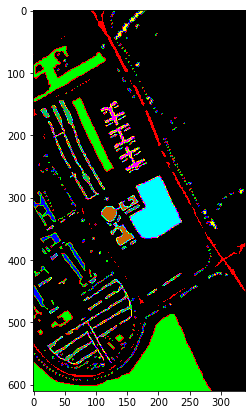

In [33]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

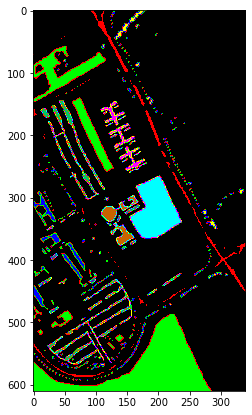

In [34]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))


In [35]:
spectral.save_rgb("PAVIA_SPECTRALNET_predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)
